# First Steps in SatMAD

This tutorial illustrates some of the basic functionalities of SatMAD (see the
[documentation](https://satmad.readthedocs.io) for the latest or more advanced
functionalities).

Many of the satellite mission analysis and design problems have four steps:
    1. Initialise an orbit
    2. Propagate the orbit to generate the trajectory over a duration
    3. Do some analysis with this trajectory
    4. Plot the results

In this tutorial we will go over these steps to show how SatMAD works.

The first step is to initialise the orbit. For this task we will start with a
telecommunications satellite on a geostationary orbit. The up-to-date orbital
elements of Turksat-4A can be retrieved from
[Celestrak website](https://celestrak.com/satcat/tle.php?CATNR=39522).

In [1]:
from satmad.propagation.tle import TLE

name = "TURKSAT 4A"
line1 = "1 39522U 14007A   20193.17132507  .00000144  00000-0  00000+0 0  9992"
line2 = "2 39522   0.0769 271.0842 0000679 241.5624 240.5627  1.00268861 23480"

tle = TLE.from_tle(line1, line2, name)

print(tle)

TURKSAT 4A
1 39522U 14007A   20193.17132507  .00000144  00000-0  00000+0 0  9992
2 39522   0.0769 271.0842 0000679 241.5624 240.5627  1.00268861 23480



This initialises the orbit from the
[Two-Line-Element](https://celestrak.com/NORAD/documentation/tle-fmt.php) data.

The next step is to propagate the orbit. In this example, we define the propagator `sgp4` with
an output stepsize of 120 seconds. We then define an interval with a start time and a duration.
Finally, we propagate the orbit with `gen_trajectory()`, taking the inputs of `tle` (initial orbit)
and propagation interval. The output is the trajectory in GCRS coordinate frame.

In [2]:
from satmad.utils.timeinterval import TimeInterval
from satmad.propagation.sgp4_propagator import SGP4Propagator
from astropy import units as u
from astropy.time import Time

# init SGP4
sgp4 = SGP4Propagator(stepsize=120 * u.s)

#  Propagate 3 days into future
interval = TimeInterval(Time("2020-07-11T00:10:00.000", scale="utc"), 3.0 * u.day)
rv_gcrs = sgp4.gen_trajectory(tle, interval)

print(rv_gcrs)

Trajectory from 2020-07-11T00:10:00.000 to 2020-07-14T00:08:00.000 in frame gcrs. (Interpolators initialised: False)


The third step is to do some analysis with this trajectory. By definition, a geostationary orbit is *stationary*
with respect to the Earth. For this simple example, we can check whether this assumption holds and
how the satellite moves in the Earth-fixed frame.

To this end, we should first convert the internal coordinates data in GCRS to the Earth-fixed (ITRS) coordinates.
The next step is to set a reference value and check how much the satellite position deviate in time
from this reference position.

Note that the coordinate transformations are handled by [Astropy](https://www.astropy.org/).

In [3]:
# convert GCRS to ITRS
rv_itrs = rv_gcrs.coord_list.transform_to("itrs")

# set reference coordinates and generate position & velocity differences
rv_itrs_ref = rv_itrs[0]

r_diff = (
    rv_itrs.cartesian.without_differentials()
    - rv_itrs_ref.cartesian.without_differentials()
)

v_diff = rv_itrs.velocity - rv_itrs_ref.velocity

# Compute max position and velocity deviation
print(f"Max position deviation: {r_diff.norm().max()}")
print(f"Max velocity deviation: {v_diff.norm().max().to(u.m / u.s)}")

Max position deviation: 81.31610203910243 km
Max velocity deviation: 5.909221339268976 m / s


This shows that the maximum deviation from the reference position was more than 80 km.
Similarly, the maximum velocity difference was more than 5 m/s. These are not
small differences and they are actually due to the force model assumptions and
orbit maintenance strategy in GEO.

However, we would like to understand these differences a little bit
more and this necessitates the final step: plotting the results.

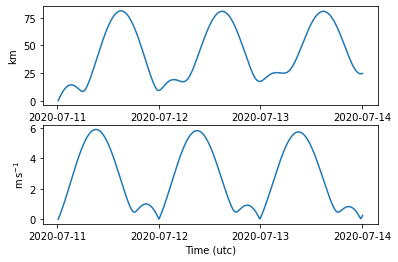

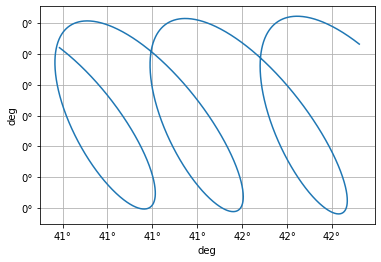

In [18]:
from astropy.visualization import time_support
from astropy.visualization import quantity_support
from matplotlib import pyplot as plt

quantity_support()
time_support()

plt.subplot(211)
plt.plot(rv_itrs.obstime, r_diff.norm())
plt.subplot(212)
plt.plot(rv_itrs.obstime, v_diff.norm().to(u.m / u.s))

plt.show()

from astropy.coordinates import EarthLocation


The results show a periodic motion with respect to the initial point, as well as a linear
departure.

Perhaps more useful is to see this motion on a latitude-longitude plot, where we can
see the how geostationary the satellite is. Usually satellite operators define a control box
in this coordinate frame and make sure the satellite stays in this box.

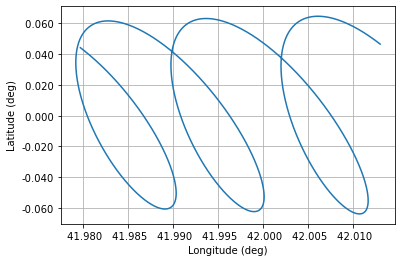

In [19]:
from matplotlib.ticker import FormatStrFormatter

# Generate lat-lon data
lla = EarthLocation.from_geocentric(
    rv_itrs.cartesian.x, rv_itrs.cartesian.y, rv_itrs.cartesian.z
)

# Show lat-lon plot
ax = plt.axes()
plt.grid()
ax.xaxis.set_major_formatter(FormatStrFormatter("% 3.3f"))
ax.yaxis.set_major_formatter(FormatStrFormatter("% 3.3f"))
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.plot(lla.lon, lla.lat)
plt.show()

We see further proof that there is a periodic motion as well as a linear drift.
Any further analysis is beyond the scope of this simple tutorial.

That said, we have shown the four fundamental steps of approaching a problem with SatMAD:
initialisation, propagation, analysis and plotting the results.